In [1]:
import numpy as np 
#from pyuoi.linear_model import UoILasso
import os, sys
sys.path.append('..')
from utils import gen_covariance, gen_beta2, gen_data, selection_accuracy, FNR, FPR

In [2]:
sigma = gen_covariance(100, 0.25, 10, 1, 0)
beta = gen_beta2(100, 10, sparsity = 0.2)
X, X_test, y, y_test, sigma_sq = gen_data(500, 100, covariance = sigma, beta = beta)

In [2]:
import pdb
import time
import matplotlib.pyplot as plt

In [3]:
from pyuoi.linear_model import UoI_Lasso

In [4]:
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression


### Replicate Simulation Study in the Adaptive Model Selection paper in order to better understand the behavior of the adaptive penalty

#### Use 50 coefficients with varying number of nonzero coefficients. Fix the sigma_squared to 1, and use uncorrelated features

In [5]:
def gen_fixed_data(n_nonzero):
    X = np.random.multivariate_normal(np.zeros(50), np.eye(50), size = 200)
    
    # generate coefficients to give as fixed R^2 of 0.75 
    
    Grammian = X.T @ X
    
    c= 0.75 * 200/(1 - 0.75)
    
    beta_mask = np.zeros((50, 1))
    beta_mask[:n_nonzero] = 1
    
    beta_0 = np.sqrt(c/np.sum(beta_mask.T @ Grammian @ beta_mask))
    
    beta = beta_0 * beta_mask
    
    noise = np.random.normal(0, 1, (200, 1))
    
    y = X @ beta + noise
    
    # Generate identically distributed test data
    X_test = np.random.multivariate_normal(np.zeros(50), np.eye(50), size = 200)
    noise_test = np.random.normal(0, 1, (200, 1))
    y_test = X_test @ beta + noise_test
    
    return X, y, X_test, y_test, beta

In [6]:
def model_loss(y, y_pred, M, penalty):
    
    n_samples = y.size
    
    if penalty == 'AICc':
        model_size_penalty = 2 * M + (2 * M**2 + 2 * M)/(n_samples - M - 1)
    else:
        model_size_penalty = penalty * M
    
    return np.linalg.norm(y.ravel() - y_pred.ravel())**2 + model_size_penalty

In [7]:
def empirical_model_loss(y, y_pred, M, penalty):
    n_samples = y.size
    rss = (y - y_pred)**2
    if penalty == 'AICc':
        model_size_penalty = 2 * M + (2 * M**2 + 2 * M)/(n_samples - M - 1)
    else:
        model_size_penalty = penalty * M
    
    llhood = n_samples/2 * (1 + np.log(np.mean(rss)))
    return 2 * llhood + model_size_penalty, 2 * llhood, model_size_penalty

In [14]:
# Run selection module over a the full gambit of non-zero coefficients. Calculate the maximum selection accuracy of all 
# candidate supports
uoil = UoI_Lasso(n_boots_sel = 50, stability_selection = 0.5, n_lambdas = 100)
max_selection_accuracy = np.zeros(50)
for k in np.arange(1, 51):
    t0 = time.time()
    X, y, X_tesy, y_test, beta = gen_data(k)
    uoil.selection(X, y)
    sa = selection_accuracy(beta.T, 1 * uoil.supports_)
    max_selection_accuracy[k - 1] = np.max(sa)
    print(time.time() - t0)

2.4850106239318848
2.529015302658081
2.7449989318847656
2.7160513401031494
2.686000347137451
2.566012382507324
2.53951358795166
2.603062629699707
2.635999917984009
3.286998748779297
3.4190025329589844
3.011998414993286
2.759999990463257
2.7081477642059326
2.8545122146606445
2.8335180282592773
2.8725056648254395
2.875183343887329
3.052097797393799
2.574051856994629
3.0895917415618896
2.762584924697876
3.743558883666992
2.970513105392456
3.0394599437713623
2.7085182666778564
2.6695165634155273
2.6920011043548584
2.6760149002075195
2.689051389694214
2.751080274581909
2.6240122318267822
2.5998876094818115
2.816999673843384
2.657860517501831
2.6665282249450684
2.781002998352051
2.719658851623535
2.6398587226867676
2.5695433616638184
2.9449989795684814
2.8450119495391846
2.900196075439453
3.0616159439086914
2.8449971675872803
2.882047414779663
2.763509511947632
2.788365602493286
2.7040019035339355
2.6749987602233887


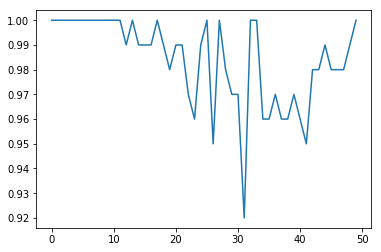

In [15]:
plt.plot(max_selection_accuracy)

In [18]:
# As a function of non-zero coefficients, fit an OLS model on the each of the candidate support sets. Visualize what the optimal 
# model would be for lambda = 2, lambda = log(n), and lambda = 2 log p coresponding to AIC, BIC, and RIC as a function of the 
# R^2 

penalties = [0, 2, np.log(200), 2 * np.log(50)]

uoil = UoI_Lasso(n_boots_sel = 50, stability_selection = 0.5, n_lambdas = 100)

# record our selection loss, MSE, and selection accuracy
full_model_scores = []
full_MSE = []
full_selection_accuracy = []
full_FNR = []
full_FPR = []

for k in np.arange(1, 51, 2):
    t0 = time.time()
    across_reps_model_scores = []
    across_reps_sa = []
    across_reps_fnr = []
    across_reps_fpr = []
    across_reps_MSE = []
    for rep in range(50):
        X, y, X_test, y_test, beta = gen_data(k)
        uoil.selection(X, y)
        coefs = np.zeros(uoil.supports_.shape)

        # Fit OLS models:
        model_scores = np.zeros((uoil.supports_.shape[0], len(penalties)))
        MSE = np.zeros(uoil.supports_.shape[0])
        sa = selection_accuracy(beta.T, 1 * uoil.supports_)
        fnr = FNR(beta.T, 1 * uoil.supports_)
        fpr = FPR(beta.T, 1 * uoil.supports_)
        for i in range(uoil.supports_.shape[0]):
            lin_model = LinearRegression()
            coefs[i, uoil.supports_[i, :]] = lin_model.fit(X[:, uoil.supports_[i, :]], y).coef_.ravel()
            # Score models
            MSE[i] = mean_squared_error(y_test, lin_model.predict(X_test[:, uoil.supports_[i, :]]))
            for j in range(len(penalties)):
                model_scores[i, j] = model_loss(y_test, lin_model.predict(X_test[:, uoil.supports_[i, :]]), 
                                                np.count_nonzero(1 * uoil.supports_[i, :]),
                                                penalties[j])
        across_reps_model_scores.append(model_scores)
        across_reps_sa.append(sa)
        across_reps_fnr.append(fnr)
        across_reps_fpr.append(fpr)
        across_reps_MSE.append(MSE)
    # Append the model_scores to the master list
    full_model_scores.append(across_reps_model_scores)
    full_MSE.append(across_reps_MSE)
    full_selection_accuracy.append(across_reps_sa)
    full_FNR.append(across_reps_fnr)
    full_FPR.append(across_reps_fpr)
    print(time.time() - t0)

134.76329159736633
142.13037133216858
131.2690327167511
131.53807830810547
132.7388002872467
133.57600164413452
150.43226599693298
157.58966159820557
135.0177779197693
135.5314645767212
135.26730632781982
135.77269196510315
136.3382489681244
138.45899963378906
136.50711750984192
138.1564576625824
150.39710974693298
142.23410272598267
145.81378364562988
138.65919828414917
144.5000147819519
141.3080244064331
143.87179923057556
138.351380109787
138.91965556144714


In [ ]:
len(full_FNR)

In [ ]:
# Save to file
import pickle
with open('model_penalty_results.dat', 'wb') as f:
    f.write(pickle.dumps(full_model_scores))
    f.write(pickle.dumps(full_MSE))
    f.write(pickle.dumps(full_selection_accuracy))
    f.write(pickle.dumps(full_FNR))
    f.write(pickle.dumps(full_FPR))

In [19]:
# Save to file
import pickle
with open('model_penalty_results2.dat', 'wb') as f:
    f.write(pickle.dumps(full_model_scores))
    f.write(pickle.dumps(full_MSE))
    f.write(pickle.dumps(full_selection_accuracy))
    f.write(pickle.dumps(full_FNR))
    f.write(pickle.dumps(full_FPR))

In [9]:
# Load from file
import pickle
with open('model_penalty_results2.dat', 'rb') as f:
    full_model_scores = pickle.load(f)
    full_MSE = pickle.load(f)
    full_selection_accuracy = pickle.load(f)
    full_FNR = pickle.load(f)
    full_FPR = pickle.load(f)

In [11]:
penalties = [0, 2, np.log(200), 2 * np.log(50)]

# Plot the MSE and selection accuracy vs the model size for the model selected via each model selection metric
best_MSE = np.zeros((25, len(penalties)))
best_sa = np.zeros((25, len(penalties)))      
best_FNR = np.zeros((25, len(penalties)))
best_FPR = np.zeros((25, len(penalties)))

for i, _ in enumerate(np.arange(1, 51, 2)):
    for j in range(len(penalties)):
        selected_model_index = [np.argmin(full_model_scores[i][k][:, j]) for k in range(50)]
        best_MSE[i, j] = np.mean(np.array([full_MSE[i][k][selected_model_index[k]] for k in range(50)]))
        best_sa[i, j] = np.mean(np.array([full_selection_accuracy[i][k][selected_model_index[k]]\
                                          /np.max(full_selection_accuracy[i][k]) for k in range(50)]))
        best_FNR[i, j] = np.mean(np.array([full_FNR[i][k][selected_model_index[k]] for k in range(50)]))
        best_FPR[i, j] = np.mean(np.array([full_FPR[i][k][selected_model_index[k]] for k in range(50)]))
        

In [ ]:
# NOTE: This result may be due to UoI selection not doing a good job in this intermediate regime at construction of good
# model supports. Rescale this by the best that the metric could possibly do given the available supports 

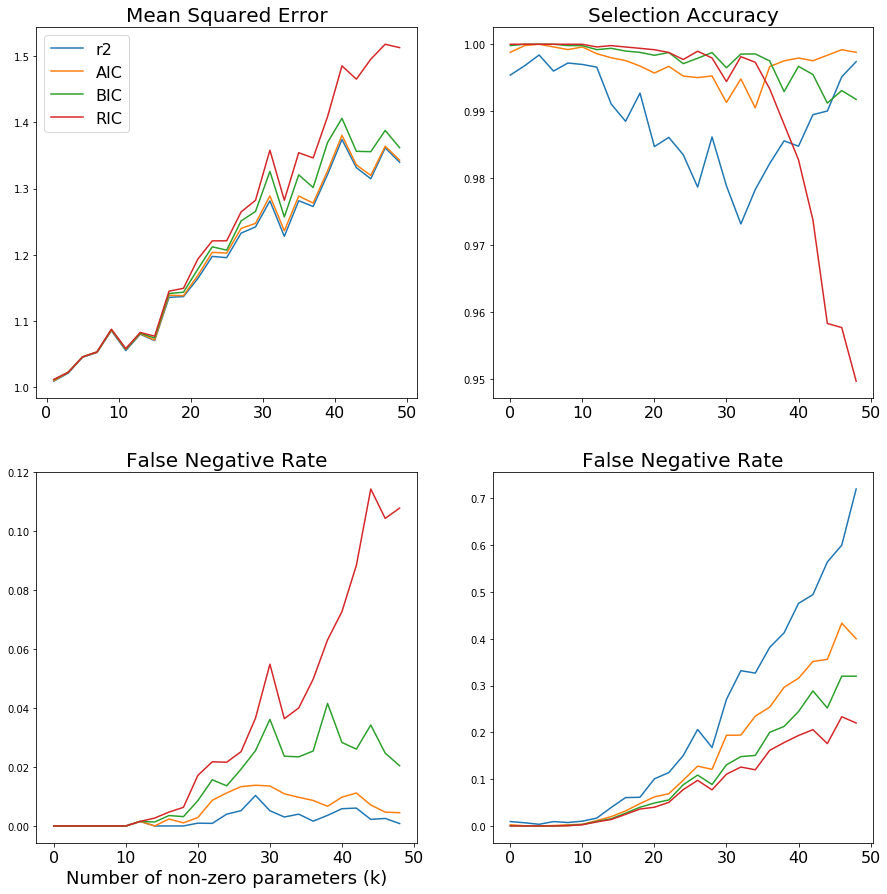

In [25]:
fig, ax = plt.subplots(2, 2, figsize = (15, 15))

ax[0, 0].plot(np.arange(1, 51, 2), best_MSE)
ax[0, 0].legend(['r2', 'AIC', 'BIC', 'RIC'], fontsize = 16)
ax[0, 0].set_title('Mean Squared Error', fontsize = 20)
ax[0, 0].set_xticklabels([0, 0, 10, 20, 30, 40, 50], fontsize = 16)

ax[0, 1].plot(best_sa)
ax[0, 1].set_title('Selection Accuracy', fontsize = 20)
ax[0, 1].set_xticklabels([0, 0, 10, 20, 30, 40, 50], fontsize = 16)

ax[1, 0].plot(best_FNR)
ax[1, 0].set_title('False Negative Rate', fontsize = 20)
ax[1, 0].set_xticklabels([0, 0, 10, 20, 30, 40, 50], fontsize = 16)
ax[1, 0].set_xlabel('Number of non-zero parameters (k)', fontsize = 18)

ax[1, 1].plot(best_FPR)
ax[1, 1].set_title('False Negative Rate', fontsize = 20)
ax[1, 1].set_xticklabels([0, 0, 10, 20, 30, 40, 50], fontsize = 16)

plt.savefig('cheating.pdf', bbox_inches = 'tight', pad_inches = 0)

In [7]:
from pyuoi.linear_model.adaptive2 import adaptive_estimation_penalty

In [8]:
# What is the adaptive lambda estimated by the procedure for different model sparsities?
n_model_sizes = 5
n_reps = 1

lambda_hats = np.zeros((10, n_reps))

uoil = UoI_Lasso(n_boots_sel = 50, stability_selection = 0.5, n_lambdas = 100)

for idx, k in enumerate(np.arange(1, 51, n_model_sizes)):
#for idx, k in enumerate([50]):
    for rep in range(n_reps):
        t0 = time.time()
        X, y, X_test, y_test, beta = gen_data(k)
        uoil.selection(X, y)

        coefs = np.zeros(uoil.supports_.shape)
        pseudo_inverses = np.zeros(uoil.supports_.shape + (200,))
        # Fit OLS models:
        for i in range(uoil.supports_.shape[0]):
            lin_model = LinearRegression()
            coefs[i, uoil.supports_[i, :]] = lin_model.fit(X[:, uoil.supports_[i, :]], y).coef_.ravel()
            support = uoil.supports_[i, :]
            projector = np.diag(1 * support)
            pseudo_inverses[i, ...] = np.linalg.pinv(X @ projector)
        
        l, g, al = adaptive_estimation_penalty(pseudo_inverses, uoil.supports_, X, y)
        lambda_hats[idx, rep] = l
        
        print(time.time() - t0)

30
23
23
21
18
18
9
9
9
9
9
9
8
8
5
5
5
5
5
5
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
20.93051052093506
28
26
22
21
20
17
12
11
11
9
9
9
9
9
9
9
9
9
9
8
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
22.936058044433594
30
23
21
21
16
13
13
13
13
13
11
11
11
9
9
9
9
9
8
8
8
8
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
26.21600079536438
37
30
27
27
26
21
21
21
21
21
21
19
19
19
19
19
18
18
17
17
14
14
14
14
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
29.342551708221436
30
25
24
17
17
17
17
17
17
17
17
17
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
24.81817865371704
30
28
25
25
21
21
21
21
21
21
19
19
19
19
19
19
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
24.460177421569824
32
28
27
27
27
21
21
21
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
19
19
19
19
24.13200068473816
33
28
28
27
25
25
25
24
24
24
24
24
24
23
23
23
23
23
23
23
23
23
23
23
23
23
23
22
22
22
22
22
22
21
21
21
21
21
21
19
26.866003036499023
30
30
28
28


In [9]:
lambda_hats

array([[1.76610579],
       [2.44537725],
       [1.22268862],
       [1.22268862],
       [1.49439721],
       [1.22268862],
       [2.98879441],
       [1.35854291],
       [4.89075449],
       [1.76610579]])

In [28]:
np.arange(1, 51, 5)

array([ 1,  6, 11, 16, 21, 26, 31, 36, 41, 46])

In [28]:
# Use the empirical loss to constrast the effect of using the MLE estimate of sigma^2

penalties = [0, 2, np.log(200), 2 * np.log(50), 'AICc']

uoil = UoI_Lasso(n_boots_sel = 50, stability_selection = 0.5, n_lambdas = 100)

# record our selection loss, MSE, and selection accuracy
full_model_scores2 = []
full_score_contributions2 = []
full_MSE2 = []
full_selection_accuracy2 = []
full_FNR2 = []
full_FPR2 = []

for k in np.arange(1, 51, 5):
    t0 = time.time()
    across_reps_model_scores = []
    across_reps_score_contributions = []
    across_reps_sa = []
    across_reps_fnr = []
    across_reps_fpr = []
    across_reps_MSE = []
    for rep in range(25):
        X, y, X_test, y_test, beta = gen_fixed_data(k)
        uoil.selection(X, y)
        coefs = np.zeros(uoil.supports_.shape)

        # Fit OLS models:
        model_scores = np.zeros((uoil.supports_.shape[0], len(penalties)))
        score_contributions = np.zeros((uoil.supports_.shape[0], len(penalties), 2))
        MSE = np.zeros(uoil.supports_.shape[0])
        sa = selection_accuracy(beta.T, 1 * uoil.supports_)
        fnr = FNR(beta.T, 1 * uoil.supports_)
        fpr = FPR(beta.T, 1 * uoil.supports_)
        for i in range(uoil.supports_.shape[0]):
            lin_model = LinearRegression()
            coefs[i, uoil.supports_[i, :]] = lin_model.fit(X[:, uoil.supports_[i, :]], y).coef_.ravel()
            # Score models
            MSE[i] = mean_squared_error(y_test, lin_model.predict(X_test[:, uoil.supports_[i, :]]))
            for j in range(len(penalties)):
                l1, l2, l3 = empirical_model_loss(y_test, lin_model.predict(X_test[:, uoil.supports_[i, :]]), 
                                                np.count_nonzero(1 * uoil.supports_[i, :]),
                                                penalties[j])
                model_scores[i, j] = l1
                score_contributions[i, j, 0] = l2
                score_contributions[i, j, 1] = l3
        across_reps_model_scores.append(model_scores)
        across_reps_score_contributions.append(score_contributions)
        across_reps_sa.append(sa)
        across_reps_fnr.append(fnr)
        across_reps_fpr.append(fpr)
        across_reps_MSE.append(MSE)
    # Append the model_scores to the master list
    full_model_scores2.append(across_reps_model_scores)
    full_score_contributions2.append(across_reps_score_contributions)
    full_MSE2.append(across_reps_MSE)
    full_selection_accuracy2.append(across_reps_sa)
    full_FNR2.append(across_reps_fnr)
    full_FPR2.append(across_reps_fpr)
    print(time.time() - t0)

78.3335337638855
79.04566526412964
75.44722533226013
74.59553575515747
77.24445033073425
79.41863417625427
85.44851279258728
87.75534534454346
89.26833152770996
85.9152626991272


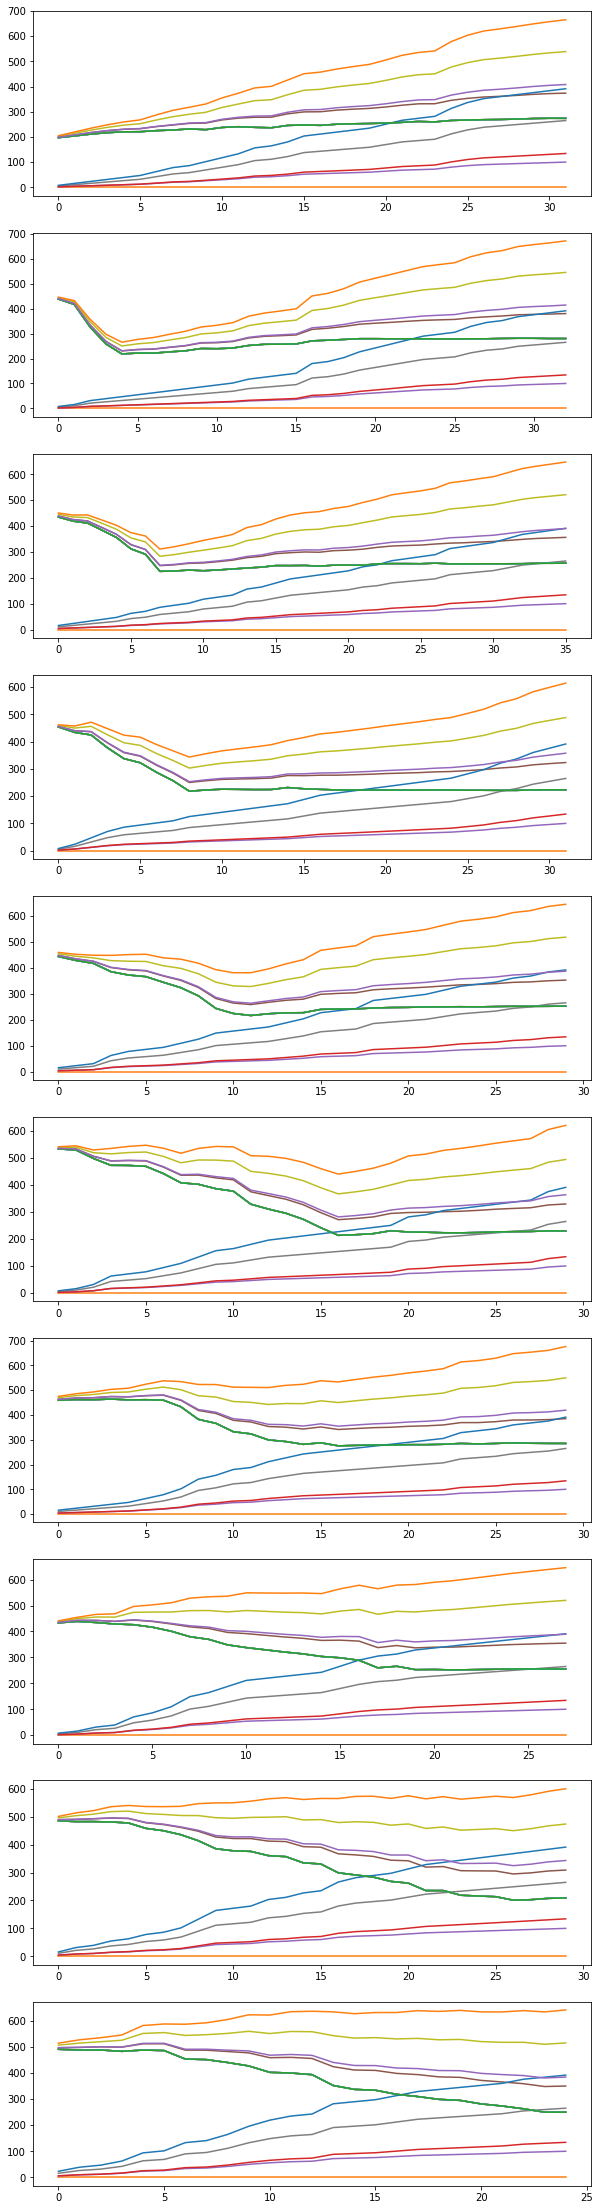

In [39]:
# Across number of non-zero parameters, for each of the candidate model supports, plot a scatter point of the
# llhood contribution to the model error vs. the model size penalty:
fig, ax = plt.subplots(10, figsize = (10, 40))
for i in range(len(full_score_contributions2)):
    colors = ['']
    for j in range(len(penalties)):
        llhood_contributions = full_score_contributions2[i][0][:, j, 0]
        penalty_contributions = full_score_contributions2[i][0][:, j, 1]
        ax[i].plot(llhood_contributions)
        ax[i].plot(penalty_contributions)
        ax[i].plot(llhood_contributions + penalty_contributions)

In [38]:
# Plot the MSE and selection accuracy vs the model size for the model selected via each model selection metric
best_MSE2 = np.zeros((10, len(penalties)))
best_sa2 = np.zeros((10, len(penalties)))      
best_FNR2 = np.zeros((10, len(penalties)))
best_FPR2 = np.zeros((10, len(penalties)))

for i, _ in enumerate(np.arange(1, 51, 5)):
    for j in range(len(penalties)):
        selected_model_index = [np.argmin(full_model_scores2[i][k][:, j]) for k in range(25)]
        best_MSE2[i, j] = np.mean(np.array([full_MSE2[i][k][selected_model_index[k]] for k in range(25)]))
        best_sa2[i, j] = np.mean(np.array([full_selection_accuracy2[i][k][selected_model_index[k]]\
                                          /np.max(full_selection_accuracy2[i][k]) for k in range(25)]))
        best_FNR2[i, j] = np.mean(np.array([full_FNR2[i][k][selected_model_index[k]] for k in range(25)]))
        best_FPR2[i, j] = np.mean(np.array([full_FPR2[i][k][selected_model_index[k]] for k in range(25)]))
       

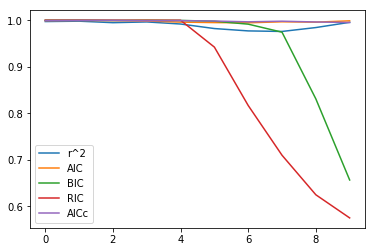

In [40]:
plt.plot(best_sa2)
plt.legend(['r^2', 'AIC', 'BIC', 'RIC', 'AICc'])

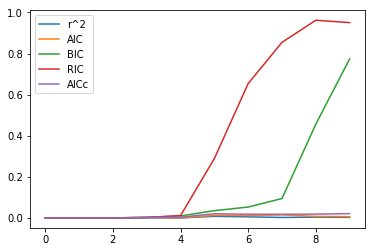

In [41]:
plt.plot(best_FNR2)
plt.legend(['r^2', 'AIC', 'BIC', 'RIC', 'AICc'])

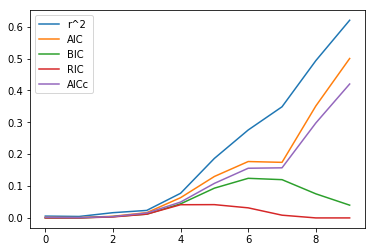

In [42]:
plt.plot(best_FPR2)
plt.legend(['r^2', 'AIC', 'BIC', 'RIC', 'AICc'])

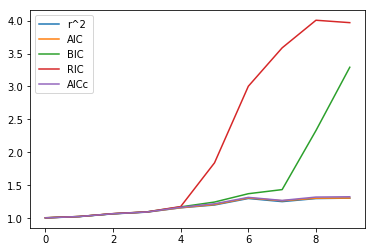

In [46]:
plt.plot(best_MSE2)
plt.legend(['r^2', 'AIC', 'BIC', 'RIC', 'AICc'])

In [57]:
# Use our cannonical data generation process - maybe AIC is being boosted by this artificial scenario
# Use the empirical loss to constrast the effect of using the MLE estimate of sigma^2

penalties = [0, 2, np.log(200), 2 * np.log(50), 'AICc']

uoil = UoI_Lasso(n_boots_sel = 50, stability_selection = 0.5, n_lambdas = 100)

# record our selection loss, MSE, and selection accuracy
full_model_scores3 = []
full_model_score_contributions = []
full_MSE3 = []
full_selection_accuracy3 = []
full_FNR3 = []
full_FPR3 = []

# Iterate over sparsities
for s in np.linspace(0.05, 1, 10):
    t0 = time.time()
    across_reps_model_scores = []
    across_reps_model_score_contributions = []
    across_reps_sa = []
    across_reps_fnr = []
    across_reps_fpr = []
    across_reps_MSE = []
    sigma = gen_covariance(100, 0, 100, 1, 0)
    for rep in range(10):
        beta = gen_beta2(100, 100, sparsity = s)
        X, X_test, y, y_test, sigma_sq = gen_data(400, 100, covariance = sigma, beta = beta)
        uoil.selection(X, y)
        coefs = np.zeros(uoil.supports_.shape)

        # Fit OLS models:
        model_scores = np.zeros((uoil.supports_.shape[0], len(penalties)))
        loss_contribution = np.zeros((uoil.supports_.shape[0], len(penalties), 2))
        MSE = np.zeros(uoil.supports_.shape[0])
        sa = selection_accuracy(beta.T, 1 * uoil.supports_)
        fnr = FNR(beta.T, 1 * uoil.supports_)
        fpr = FPR(beta.T, 1 * uoil.supports_)
        for i in range(uoil.supports_.shape[0]):
            lin_model = LinearRegression()
            coefs[i, uoil.supports_[i, :]] = lin_model.fit(X[:, uoil.supports_[i, :]], y).coef_.ravel()
            # Score models
            MSE[i] = mean_squared_error(y_test, lin_model.predict(X_test[:, uoil.supports_[i, :]]))
            for j in range(len(penalties)):
                
                l1, l2, l3 = empirical_model_loss(y_test, lin_model.predict(X_test[:, uoil.supports_[i, :]]), 
                                                np.count_nonzero(1 * uoil.supports_[i, :]),
                                                penalties[j])
                model_scores[i, j] = l1
                loss_contribution[i, j, 0] = l2
                loss_contribution[i, j, 1] = l3
        across_reps_model_scores.append(model_scores)
        across_reps_model_score_contributions.append(loss_contribution)
        across_reps_sa.append(sa)
        across_reps_fnr.append(fnr)
        across_reps_fpr.append(fpr)
        across_reps_MSE.append(MSE)
    # Append the model_scores to the master list
    full_model_scores3.append(across_reps_model_scores)
    full_model_score_contributions.append(across_reps_model_score_contributions)
    full_MSE3.append(across_reps_MSE)
    full_selection_accuracy3.append(across_reps_sa)
    full_FNR3.append(across_reps_fnr)
    full_FPR3.append(across_reps_fpr)
    print(time.time() - t0)

42.97086048126221
41.96303200721741
42.960999965667725
42.60913896560669
41.999998807907104
42.49154281616211
42.38499999046326
42.90541219711304
43.432448863983154
43.26699924468994


In [58]:
# Plot the MSE and selection accuracy vs the model size for the model selected via each model selection metric
best_MSE3 = np.zeros((10, len(penalties)))
best_sa3 = np.zeros((10, len(penalties)))      
best_FNR3 = np.zeros((10, len(penalties)))
best_FPR3 = np.zeros((10, len(penalties)))

n_reps = 10

for i, _ in enumerate(np.linspace(0.05, 1, 10)):
    for j in range(len(penalties)):
        selected_model_index = [np.argmin(full_model_scores3[i][k][:, j]) for k in range(n_reps)]
        best_MSE3[i, j] = np.mean(np.array([full_MSE3[i][k][selected_model_index[k]] for k in range(n_reps)]))
        best_sa3[i, j] = np.mean(np.array([full_selection_accuracy3[i][k][selected_model_index[k]]\
                                          /np.max(full_selection_accuracy3[i][k]) for k in range(n_reps)]))
        best_FNR3[i, j] = np.mean(np.array([full_FNR3[i][k][selected_model_index[k]] for k in range(n_reps)]))
        best_FPR3[i, j] = np.mean(np.array([full_FPR3[i][k][selected_model_index[k]] for k in range(n_reps)]))
       

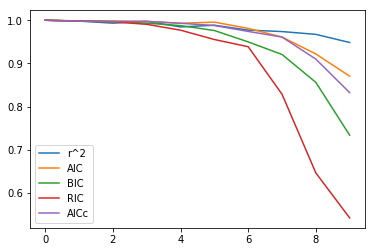

In [60]:
plt.plot(best_sa3)
plt.legend(['r^2', 'AIC', 'BIC', 'RIC', 'AICc'])

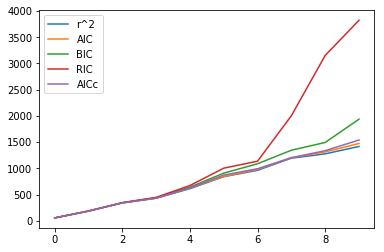

In [61]:
plt.plot(best_MSE3)
plt.legend(['r^2', 'AIC', 'BIC', 'RIC', 'AICc'])

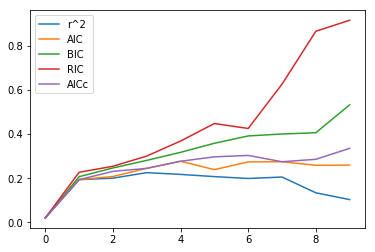

In [62]:
plt.plot(best_FNR3)
plt.legend(['r^2', 'AIC', 'BIC', 'RIC', 'AICc'])

In [64]:
# Use our cannonical data generation process - maybe AIC is being boosted by this artificial scenario
# Use the empirical loss to constrast the effect of using the MLE estimate of sigma^2

penalties = [0, 2, np.log(200), 2 * np.log(50), 'AICc']

uoil = UoI_Lasso(n_boots_sel = 50, stability_selection = 0.5, n_lambdas = 100)

# record our selection loss, MSE, and selection accuracy
full_model_scores4 = []
full_model_score_contributions2 = []
full_MSE4 = []
full_selection_accuracy4 = []
full_FNR4 = []
full_FPR4 = []

# Iterate over sparsities
for s in np.linspace(0.05, 1, 10):
    t0 = time.time()
    across_reps_model_scores = []
    across_reps_model_score_contributions = []
    across_reps_sa = []
    across_reps_fnr = []
    across_reps_fpr = []
    across_reps_MSE = []
    sigma = gen_covariance(200, 0, 200, 1, 0)
    for rep in range(1):
        beta = gen_beta2(200, 200, sparsity = s)
        X, X_test, y, y_test, sigma_sq = gen_data(800, 200, covariance = sigma, beta = beta)
        uoil.selection(X, y)
        coefs = np.zeros(uoil.supports_.shape)

        # Fit OLS models:
        model_scores = np.zeros((uoil.supports_.shape[0], len(penalties)))
        loss_contribution = np.zeros((uoil.supports_.shape[0], len(penalties), 2))
        MSE = np.zeros(uoil.supports_.shape[0])
        sa = selection_accuracy(beta.T, 1 * uoil.supports_)
        fnr = FNR(beta.T, 1 * uoil.supports_)
        fpr = FPR(beta.T, 1 * uoil.supports_)
        for i in range(uoil.supports_.shape[0]):
            lin_model = LinearRegression()
            coefs[i, uoil.supports_[i, :]] = lin_model.fit(X[:, uoil.supports_[i, :]], y).coef_.ravel()
            # Score models
            MSE[i] = mean_squared_error(y_test, lin_model.predict(X_test[:, uoil.supports_[i, :]]))
            for j in range(len(penalties)):
                
                l1, l2, l3 = empirical_model_loss(y_test, lin_model.predict(X_test[:, uoil.supports_[i, :]]), 
                                                np.count_nonzero(1 * uoil.supports_[i, :]),
                                                penalties[j])
                model_scores[i, j] = l1
                loss_contribution[i, j, 0] = l2
                loss_contribution[i, j, 1] = l3
        across_reps_model_scores.append(model_scores)
        across_reps_model_score_contributions.append(loss_contribution)
        across_reps_sa.append(sa)
        across_reps_fnr.append(fnr)
        across_reps_fpr.append(fpr)
        across_reps_MSE.append(MSE)
    # Append the model_scores to the master list
    full_model_scores4.append(across_reps_model_scores)
    full_model_score_contributions2.append(across_reps_model_score_contributions)
    full_MSE4.append(across_reps_MSE)
    full_selection_accuracy4.append(across_reps_sa)
    full_FNR4.append(across_reps_fnr)
    full_FPR4.append(across_reps_fpr)
    print(time.time() - t0)

16.187996864318848
16.746999502182007
16.868000268936157
17.30408549308777
17.81203603744507
18.39099407196045
18.318157196044922
18.436051845550537
18.865000247955322
18.047000885009766


In [65]:
# Plot the MSE and selection accuracy vs the model size for the model selected via each model selection metric
best_MSE4 = np.zeros((10, len(penalties)))
best_sa4 = np.zeros((10, len(penalties)))      
best_FNR4 = np.zeros((10, len(penalties)))
best_FPR4 = np.zeros((10, len(penalties)))

n_reps = 1

for i, _ in enumerate(np.linspace(0.05, 1, 10)):
    for j in range(len(penalties)):
        selected_model_index = [np.argmin(full_model_scores4[i][k][:, j]) for k in range(n_reps)]
        best_MSE4[i, j] = np.mean(np.array([full_MSE4[i][k][selected_model_index[k]] for k in range(n_reps)]))
        best_sa4[i, j] = np.mean(np.array([full_selection_accuracy4[i][k][selected_model_index[k]]\
                                          /np.max(full_selection_accuracy4[i][k]) for k in range(n_reps)]))
        best_FNR4[i, j] = np.mean(np.array([full_FNR4[i][k][selected_model_index[k]] for k in range(n_reps)]))
        best_FPR4[i, j] = np.mean(np.array([full_FPR4[i][k][selected_model_index[k]] for k in range(n_reps)]))
       

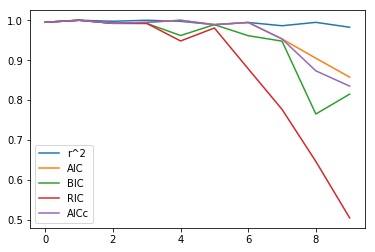

In [66]:
plt.plot(best_sa4)
plt.legend(['r^2', 'AIC', 'BIC', 'RIC', 'AICc'])

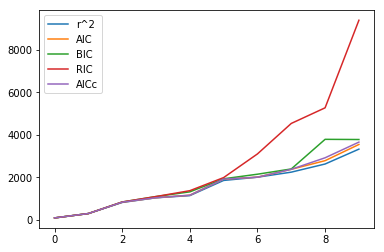

In [67]:
plt.plot(best_MSE4)
plt.legend(['r^2', 'AIC', 'BIC', 'RIC', 'AICc'])

In [ ]:
# What is the adaptive lambda estimated by the procedure for different model sparsities? Use empirical model less and 
n_model_sizes = 5
n_reps = 1

lambda_hats = np.zeros((10, n_reps))

uoil = UoI_Lasso(n_boots_sel = 50, stability_selection = 0.5, n_lambdas = 100)

for idx, k in enumerate(np.arange(1, 51, n_model_sizes)):
#for idx, k in enumerate([50]):
    for rep in range(n_reps):
        t0 = time.time()
        X, y, X_test, y_test, beta = gen_data(k)
        uoil.selection(X, y)

        coefs = np.zeros(uoil.supports_.shape)
        pseudo_inverses = np.zeros(uoil.supports_.shape + (200,))
        # Fit OLS models:
        for i in range(uoil.supports_.shape[0]):
            lin_model = LinearRegression()
            coefs[i, uoil.supports_[i, :]] = lin_model.fit(X[:, uoil.supports_[i, :]], y).coef_.ravel()
            support = uoil.supports_[i, :]
            projector = np.diag(1 * support)
            pseudo_inverses[i, ...] = np.linalg.pinv(X @ projector)
        
        l, g, al = adaptive_estimation_penalty(pseudo_inverses, uoil.supports_, X, y)
        lambda_hats[idx, rep] = l
        
        print(time.time() - t0)